# Simple Finite Element Method Algorithm

#### Author: Victor Alexander Torres

## ZURU interview process

In this notebook, we provide a simple and very generic implementation of the Finite Element Method Algorithm to solve Poissons Equation in 2D rectangle. Here, we are going to  provide the details of the implementation, provide some examples and describe what would be some future improvements for the same project. 

# Poisson's Equation 

Poisson's equation is a fundamental partial differential equation in the field of mathematical physics. In two dimensions, it can be expressed as 


$$- \Delta u(x,y) = f(x,y)$$
where $\Delta$ denotes the Laplace operator, $u(x,y)$ and $f(x,y)$ is a known source term.  

 This equation arises in various applications, including electrostatics where it describes the potential field generated by a static charge distribution, in heat transfer modeling the temperature distribution within various objects, or in fluid dynamics simulating the velocity potential in fluid flow. Solving this equation, provides insights into diverse physical phenomena, and represents a perfect starting point to better understand more complex models described in terms of Partial Differential Equations in the field of engineering and scientific research.

In reality, solving PDEs is a complicated tasks. These equations normally depend on the geometry of the system, the source term and the different possible boundary conditions we impose. Problems like the impossibility to find analytical solutions make numerical methods an excellent tool to use for solving PDEs. In this document we are going to focus on the Finite Element Methods that allows to recast  PDEs into an algebraic expression by means of variational calculus  that guarantees the existence of a solution in the so called weak-form. Therefore, we end up with a well-posed PDE that satisfies the following conditions:
<ul>
    <li>A solution exists</li>
    <li>The solution is unique</li>
    <li> The solution depends continuosly on the data (initial conditions, boundary conditions, right hand side). </li>
</ul>

# Finite Element Method

The Finite Element Method (FEM) is a powerful computational technique used to solve differential equations that are formulated from physical problems defined over complex geometries. Its wide applicability spans from engineering disciplines to physics, making it essential for solving problems in structural analysis, fluid dynamics, heat transfer, etc.

The framework is based in two ideas:

<ul>
    <li> Recasting PDEs into the weak formulation </li>
    <li>  Approximating The Space Of Solutions </li>
</ul>


Now we are going to briefly describe both ideas using as an example the Poissons equation.


## Weak Formulation

Exact solutions to many physical problems governed by partial differential equations (PDEs) are often unattainable, especially in non-ideal or real-world conditions. Mathematicians invented the concept of weak solution. 

By considering a smooth test function $\phi$  that vanishes on the boundary $\partial\Omega$  (compact support) we can multiply it to the Poissons equation  and by using integration by parts to arrive to 

$$\int_{\Omega}\nabla u(x)\nabla\phi(x) = \int_{\Omega}f(x)\cdot \phi(x) dx$$

We can rewrite our system in functional form , first by considering as $V:= H^{1}_{0}(\Omega)$(Sobolev space) as our space of functions that them and its first derivatives are square integrable and vanish on the boundary of the domain $\Omega$. Then, we can rewrite our system using bilinear and linear forms. 

$$ a(u,v) := \int_{\Omega} \nabla u(x)\nabla v(x)dx$$
$$F(v) := \int_{\Omega} f(x) \cdot v(x) dx$$

to have 

$$a(u,v) =F(v) \text{ for } v \text{ } \epsilon \text{ } V $$

Since a is continuous and coercive and F is continuous linear, Lax-Milgram Theorem can be used to prove the existence and uniqueness of the Poissons equation in the weak form. 

## Approximating the Space of Solutions

In practice, all this mathematical formulation assumes the use of an infinite functional space. Since we can only count to finite quantities we can use then Galerkin approximation and instead consider a finite subspace $V_{h} \leq V$ to solve the problem practically.  In such space, the weak formulation in functional form becomes

$$ a(u_{h},v_{h}) = F(v_{h}) \text{     } \forall \text{} v_{h} \text{} \epsilon \text{} V_{h} $$

By choosing an appropiate $V_{h}$ , Cea's Lemma

$$||u - u_{h}||_{V} \leq \inf_ {v \epsilon V_{h}} || u - v_{h}||_{V}\frac{\gamma}{\alpha}$$

tells us that, up to a constant factor, $u_{h}$ is the best approximation of $u$ in the space $V_{h}$. 

To numerically solve our problem we need to pose our finite formulation into a matrix form. First, we define the basis of $V_{h}$ as $V_{h} = <v_{1},...,v_{n}>$ and the matrices 

$$A : = (A_{i,j})_{i,j} = (a(v_{j},v_{i})){i,j} $$

also known as stiffness matrix, and the load vector :

$$ b := (b_{i})_{i} = (F(v_{i}))_{i} $$

Finally, we define 

$$ u_{h} := \sum^{n}_{i=1} u_{i}v_{i}$$

So, our problem translates into solving a matrix equation of the form
$$ A \vec{u} =b $$

## Choosing $V_{h}$ and FEM implementation

An appropiate $V_{h}$ should be dense (in V) enough to contain most of the good approximations to the solution $u$.
$V_{h}$ must have the basis that allows us to compute $a(v_{i},v_{j})$, and $F(v_{i})$. And for computational efficiency, the basis of $V_{h}$ should have mostly zeros so matrix A is sparse and the linear system easier to solve. 

On that regard, FEM is implemented  by meshing the domain $\Omega$ with a particular geometry and then define the basis on such domain. 

Normally, in 2D a triangle mesh is  used and we define basis using piecewise polynomials on each triangle of the mesh belonging to $\Omega$.

Such polynomials have value 1 on one node, and zero on all the other nodes of the elements. The good thing is that such functions have local support within the elementss surrounding the node. So, A will be a sparse matrix as desired. 


# FEM Implementation for Poisson's equation

Now, we will start implementing a FEM solver for the Poissons equation in 2D

$$ - \Delta u(x,y) = f(x,y) $$
We are going to considerg a rectangle domain $\Omega$ and we are going to impose Drichlet boundary conditions

$$ u(x) = 0  \text{         } \forall \text{  } x \text{  } \epsilon \text{   } \partial\Omega. $$



The implementation will consist into 8 steps :

1) Creating Mesh.
2) Define basis functions.
3) Construct local stiffness matrix A 
4) Assembly the global stiffness matrix using affine transformations
5) Find right-hand side b initial loading vector.
6) Impose boundary conditions o
7) Solve the linear system
8) Convergence and mesh refinement analysis

# Implementation: 1) Creating Mesh

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import mesh as mesh
import basis_baryo as b_basis
import stiffness as stiffness
import force as force
import c_boundaries as boundaries
import FEM as FEM
from matplotlib import rc

%config InlineBackend.figure_format = "retina"
rc('text', usetex=True)
rc('font', family='serif')


As mentioned above, we define a triangular mesh within the rectangle. Such part is implemented in the file mesh.py from our project folder.

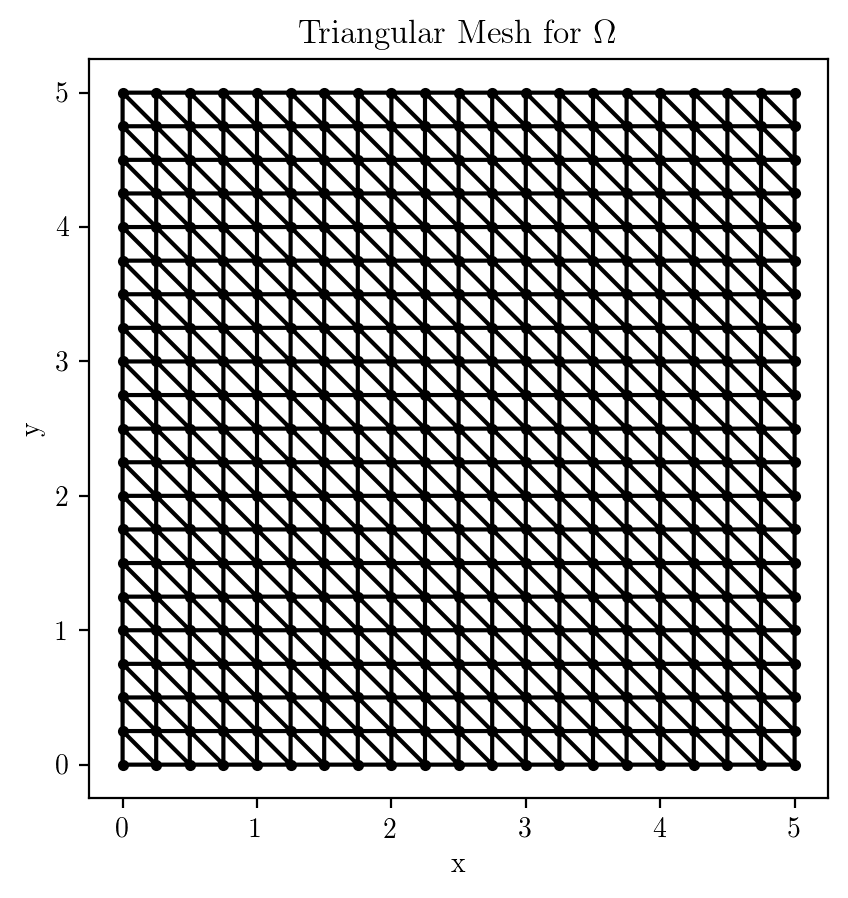

In [2]:
# Dimensions of the rectangular domain

w = 5.0 # width of the rectangle (x direction)
h = 5.0 # height of the rectangle (y direction)

nx = 20  # number of divisions of the rectangle along x
ny = 20  # number of divisions of the rectangle along y

# Create the mesh
nodes, triang_elements, num_nodes , num_elements, X_plot, Y_plot  = mesh.generate_mesh(w, h, nx, ny)

# Plot the mesh
mesh.plot_mesh(nodes, triang_elements)

## Implementation: 2) Compute basis functions

For our second part of the method implementation, we need to calculate the basis of our space $V_{h}$. As mention above we are going to use piecewise polynomials to describe each of the three node in the triangular elements.  

There will be as many polynomials as there are nodes, so we can index each polynomial similarly as we index the nodes. 

At this point, instead of working with cartesian coordinates we will use introduce barycentric coordinates systems. It allows us to describe any point within a given triangle in terms of barycentric coordinates as:  
       $$ (x, y) = \lambda_{1}(x_1, y_1) + \lambda_{2}(x_2, y_2) + \lambda_{3}(x_3, y_3) $$
        where $\lambda_{1}$, $\lambda_{2}$, and $\lambda_{3}$ are the barycentric coordinates.

So, to form a triangle with the nodes of each element we need to solve the following systems of equations

$$\begin{pmatrix}
x_{1} & x_{2} & x_{3} \\ 
y_1 & y_2 & y_3 \\ 
1 & 1  & 1
\end{pmatrix} \begin{pmatrix}
\lambda_1\\ 
\lambda_2\\ 
\lambda_3
\end{pmatrix} = \begin{pmatrix}
x\\ 
y\\ 
1
\end{pmatrix}$$

where $x_i ,y_i$ are the $x,y$ components of the i-th node.  On the right hand side, (x,y) is the point within a given triangle we want to describe and the last row comes from the fact that $\sum_{i=1}^{3} \lambda_{i} = 1$.  And $\lambda_{i} =1$ if the point we want to describe  is the i-th node. So, basically our values or $\lambda$ are the basis function for each element.

In our code, such implementation is provided in the basis_baryo.py module

For example, if we want to describe a point within the first triangular element in our mesh we do:

In [3]:
# Retrieve the points of the nodes(vertices) in the first element.
vertices = nodes[triang_elements[0]]

# Define the basis function for the point (x = 0.33 , y = 0.33) in the first triangular element
lambdas = b_basis.compute_basis_function(vertices,0.1, 0.1)
print("Basis Function Values at point (0.33, 0.33). [lambda_1, lambda_2, lambda_3]=", lambdas)

# Define the basis function for the first node i.e. point (x = 0. , y = 0) in the first triangular element
lambdas = b_basis.compute_basis_function(vertices,0., 0.)
print("Basis Function Values at first node (0., 0.). [lambda_1, lambda_2, lambda_3]=", lambdas)

Basis Function Values at point (0.33, 0.33). [lambda_1, lambda_2, lambda_3]= [0.2 0.4 0.4]
Basis Function Values at first node (0., 0.). [lambda_1, lambda_2, lambda_3]= [1. 0. 0.]


## Implementation : 3) Construct the local stiffness matrix 

For this part we recall to the expressions for the stiffness matrix. Namely,

$$ A(v_i,v_j)_{i,j} = \int_{\Omega} \nabla\lambda_{i} \nabla \lambda_{j} dx $$


To avoid complications when calculating the gradients. We rather use the mathematical trick of constructing a reference triangle K and then perform an affine transformation to map such reference triangle to each triangle of the mesh and therefore to its gradients. It is worth noting that we can either use a triangle element from our own mesh or a simple triangle with arbitrary points. To avoid using additional process  within our subroutines, we rather consider a generic triangle with points 


$P_1=(0,0)$ , $P_2 = (1,0)$, $P_3 = (0,1)$

The gradient for each $\lambda$ component in its respective coordinate system is given by

$ \nabla \lambda_{1} = \begin{bmatrix}
\frac{y_2 -y_3}{2A}\\ 
\frac{x_3 - x_2}{2A}
\end{bmatrix} $ ,  $\nabla \lambda_{2} = \begin{bmatrix}
\frac{y_3 -y_1}{2A}\\ 
\frac{x_1 - x_3}{2A}
\end{bmatrix}$, $\nabla \lambda_{3} = \begin{bmatrix}
\frac{y_1 -y_2}{2A}\\ 
\frac{x_2 - x_1}{2A}
\end{bmatrix}$

Then $ \nabla \lambda_{1} = \begin{bmatrix}
-1\\ 
-1
\end{bmatrix} $ ,  $\nabla \lambda_{2} = \begin{bmatrix}
1\\ 
0
\end{bmatrix}$, $\nabla \lambda_{3} = \begin{bmatrix}
0\\ 
1
\end{bmatrix}$

To go from reference triangle to an actual triangle in the mesh, an affine transformation is used. This transformation maps the reference triangle coordinates $(\xi,\eta)$ to the actual triangle coordinates (x,y) by solving

$$ \begin{pmatrix}
x\\ 
y
\end{pmatrix} = \begin{pmatrix}
x_1 & x_2 - x_1 & x_3 - x_1\\ 
y_1 & y_2-y_1 & y_3 - y_1
\end{pmatrix}\begin{pmatrix}
1\\ 
\xi\\ 
\eta
\end{pmatrix}$$


The Jacobian matrix of this transformation, which is necessary to convert integrals from the reference to the actual domain, is given by

$J = \begin{bmatrix}
\frac{\partial x}{\partial\xi} & \frac{\partial x}{\partial\eta} \\ 
 \frac{\partial y}{\partial\xi}& \frac{\partial y}{\partial\eta}
\end{bmatrix} =\begin{bmatrix}
x_2 - x_1 & x_3 - x_1 \\ 
 y_2 - y_1 & y_3 - y_1
\end{bmatrix}$


So, finally to go from reference to actual triangular elements we have

$$\nabla \lambda_{real} = J^{-1} \nabla \lambda_{ref}$$

Finally, our expression for the stiffness matrix becomes

$$ A(v_i,v_j)_{i,j} = \int_{\Omega} \nabla\lambda_{i} \nabla \lambda_{j} dx = \int_{\Omega} J^{-1}_{i}\nabla\lambda_{ref} J^{-1}_{j}\nabla\lambda_{ref}  dx \approx area *  J^{-1}_{i}\nabla\lambda_{ref} J^{-1}_{j}\nabla\lambda_{ref}  $$



## Implementation: 4) Assembly global stiffness matrix

Finally, we assembly our global stiffness matrix of size $n\times n $ where $n$ is the number of nodes in the element. Calculating the local stiffness matrix at each element. 


We implemented such routines in the stiffness.py module. 

For our example, we can calculate the global stiffness matrix using the function calculate_global_stiffness in stiffness.py module

In [4]:
A_global = stiffness.calculate_global_stiffness(nodes, triang_elements, num_nodes, num_elements)

## Implementation: 5) Assembly initial load vector 

We continue by considering the right hand since of the equation in the weak form, namely


$$(b_{i})_{i} = (F(v_{i}))_{i}  = \int_{\Omega}f(x,y)\lambda_i dx$$

We have a load function for each node of the mesh. For calculating the integral, we are going to use the simple midpointrule. Such method correspond to evaluating the function at the midpoint of the domain of the element and multiple by its area. Since once we increase the number of elements, the element's domain gets smaller and the error term in our approximation is reduced. Aditionally, by considering smaller domains we beter capture the coarse-grain variation of the force across the entire element.

So, for each triangular element we will have that

$$(F(v_{i}))_{i}  = \int_{\Omega}f(x,y)\lambda_i dx \approx area * f(x_{centroid},y_{centroid}) *\lambda_{i}$$

So, at each element we will get three components of the global load vector, and then we can assemble the global one. 

Such subroutines are implemented in our force.py module.

Since we want to test different source functions, we rather not included the force in our subroutines. We will specify them here.

Continuing with our example, we will consider a constant force for the whole rectangle. This is

In [5]:
# Constant source function
def source_function(x,y):
    return 10

# Assemble the load vector
F = force.assemble_load_vector(nodes, triang_elements, source_function)

## Implementation: 6) Apply boundary conditions

Since we have Dirichlet boundary conditions across all the surface of the rectangle. We have created two functions in our c_boundaries.py module so that first we can identify the points that corresponds to the boundary in both the stiffness matrix and load vector and assigned them to zero. 

In [6]:

# Define the bounds of the rectangular domain
mesh_bounds = [0, w, 0, h]   # [x_min, x_max, y_min, y_max]

# Identify the nodes at boundary
boundary_nodes = boundaries.identify_b_nodes_by_coord(nodes, mesh_bounds)

# Apply Dirichlet boundary conditions to A, F
A_final, F_final = boundaries.apply_dirichlet(A_global, F, boundary_nodes)


# Implementation: 7) Solve the linear system 

Lastly, we can find the solution by solving the linear system. 

In [7]:
# Find the nodal values
xi = sp.sparse.linalg.spsolve(A_final, F_final)


## Plot the solution

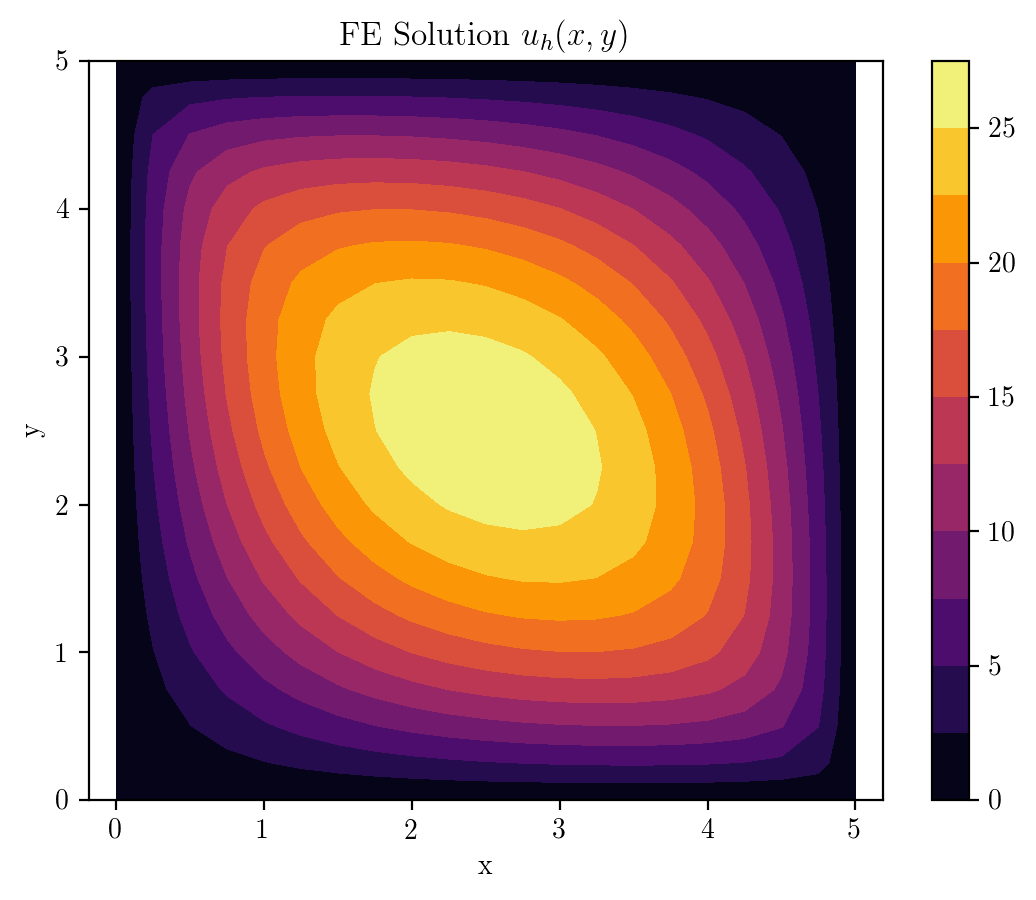

In [8]:
FEM.plot_solution(X_plot, Y_plot, xi)

# Results: Analyze convergence using a test case

Now, we are going to analyze the convergence of the method. For that we need to define how to estimate the error. For our case we use the $L_{2}$ norm defined as

$$||u_{true}- u_{h}||_{V} =  \left(\int_{\Omega} (u_{true} - u_{h})^{2}d\Omega \right)^{1/2} $$

For that, it is customary to define a system that has analytical solution so we can compare with our results and see how the error behaves as we increase the number of  triangular elements

Therefore our new system will be


$$-\Delta u(x,y) = f(x,y) $$

where 
$$f(x,y)= 2\pi^{2} sin(\pi x)cos(\pi y)$$

For a domain $\Omega = [0,1]\times[0,1]$, the analytical solution is 

$$ u(x,y) = sin(\pi x)sin(\pi y) $$



Solving now with implemented FEM we have that


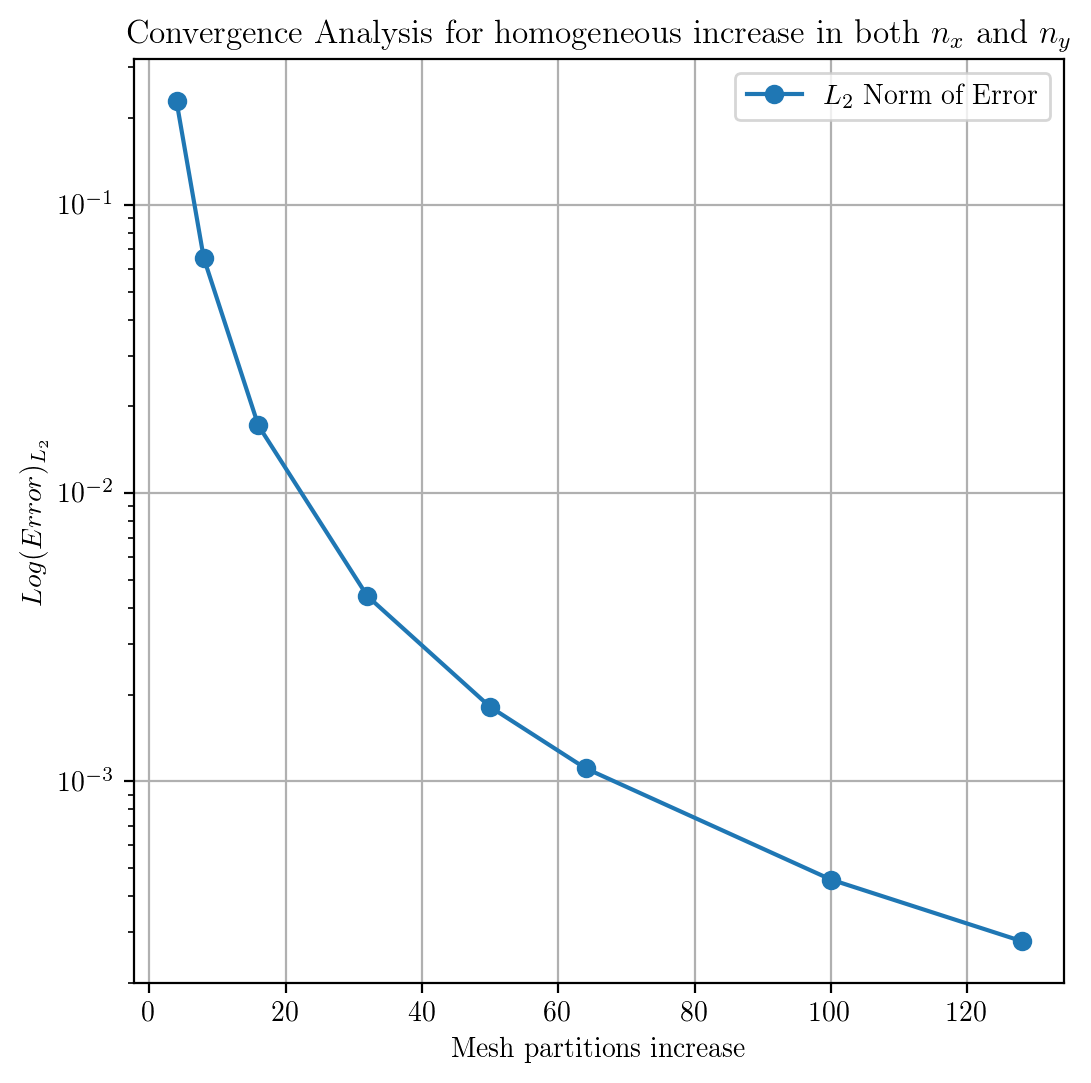

In [15]:
# Define the analytical solution
def analytical_solution(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)


# Define the source test function
def source_function(x,y):
    return 2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

# Mesh partitions to use as nx, ny
mesh_partitions = [4,8,16,32,50, 64,100, 128]  

# Define the dimensions of the rectangular domain
w = 1.0
h = 1.0

errors = []
nodes = []
triangles = []
solutions = []

for h in mesh_partitions:
    nx = h
    ny = h
    u_approx, nodes = FEM.FEM_solver(w, h, nx, ny, source_function)
    # Assume numerical_solution and analytical_solution are sampled at the same points
    # Compute error
    error = np.linalg.norm(u_approx - analytical_solution(nodes[:,0],nodes[:,1]), ord=2)
    errors.append(error)

# Plotting convergence
plt.figure(figsize=(6, 6))
plt.plot(mesh_partitions, errors, '-o', label='$L_{2}$ Norm of Error')
plt.xlabel('Mesh partitions increase')
plt.ylabel('$Log(Error)_{L_{2}}$')
plt.title('Convergence Analysis for homogeneous increase in both $n_{x}$ and $n_{y}$')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()



Although the error seems to decrease, by generically reducing the mesh, it seems that it does not reduces so fast. It seems that the method is working but better optimization techniques are needed. 

For example, if we now increase the number of divisions in $n_x$  exponentially but we only increase $n_{y}$ as $n_x /2$ we obtain a much better convergence.


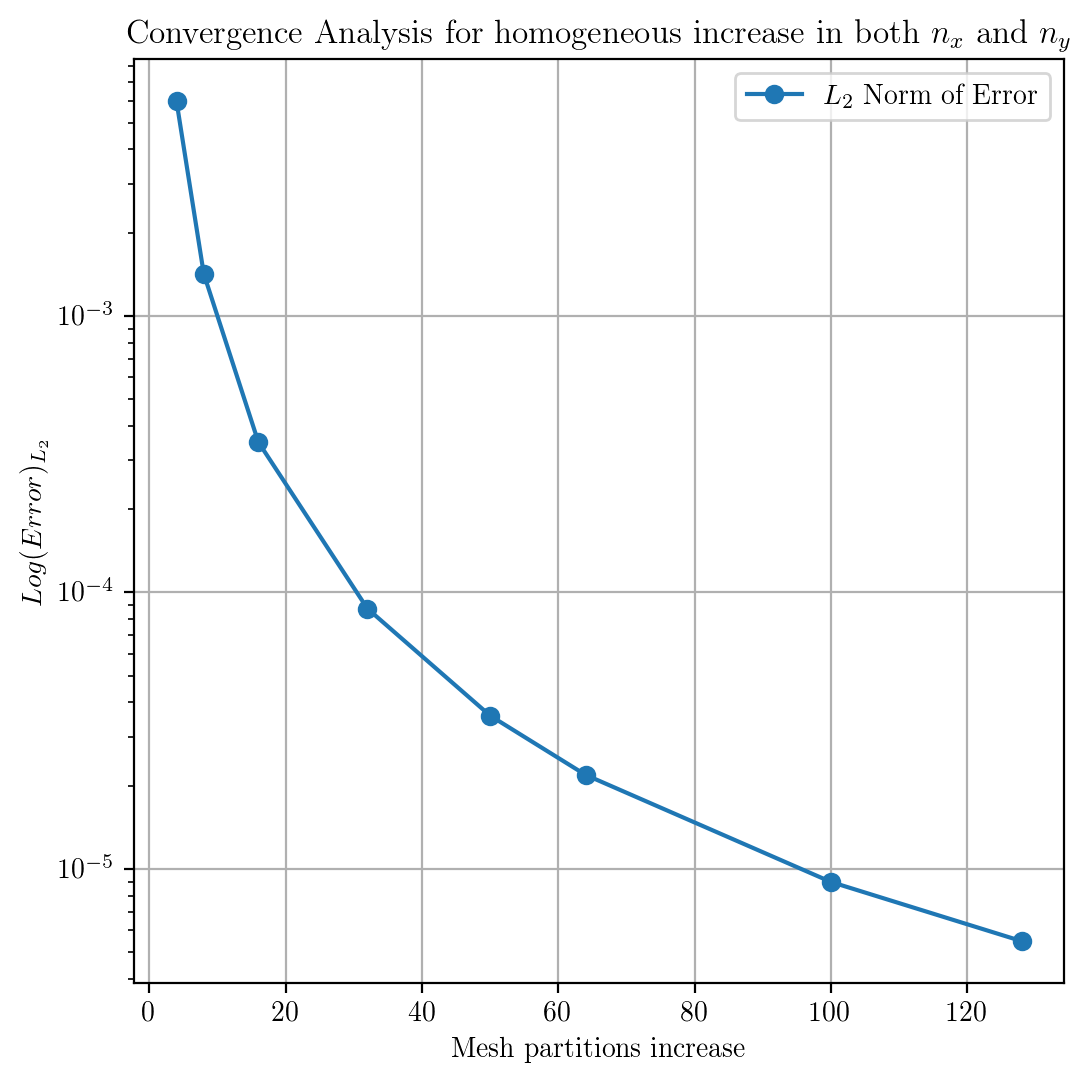

In [16]:
errors = []

for h in mesh_partitions:
    nx = h
    ny = int(h/2)
    u_approx, nodes = FEM.FEM_solver(w, h, nx, ny, source_function)
    # Assume numerical_solution and analytical_solution are sampled at the same points
    # Compute error
    error = np.linalg.norm(u_approx - analytical_solution(nodes[:,0],nodes[:,1]), ord=2)
    errors.append(error)

# Plotting convergence
plt.figure(figsize=(6, 6))
plt.plot(mesh_partitions, errors, '-o', label='$L_{2}$ Norm of Error')
plt.xlabel('Mesh partitions increase')
plt.ylabel('$Log(Error)_{L_{2}}$')
plt.title('Convergence Analysis for homogeneous increase in both $n_{x}$ and $n_{y}$')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

But if we do the opposite, the algorithm goes really bad

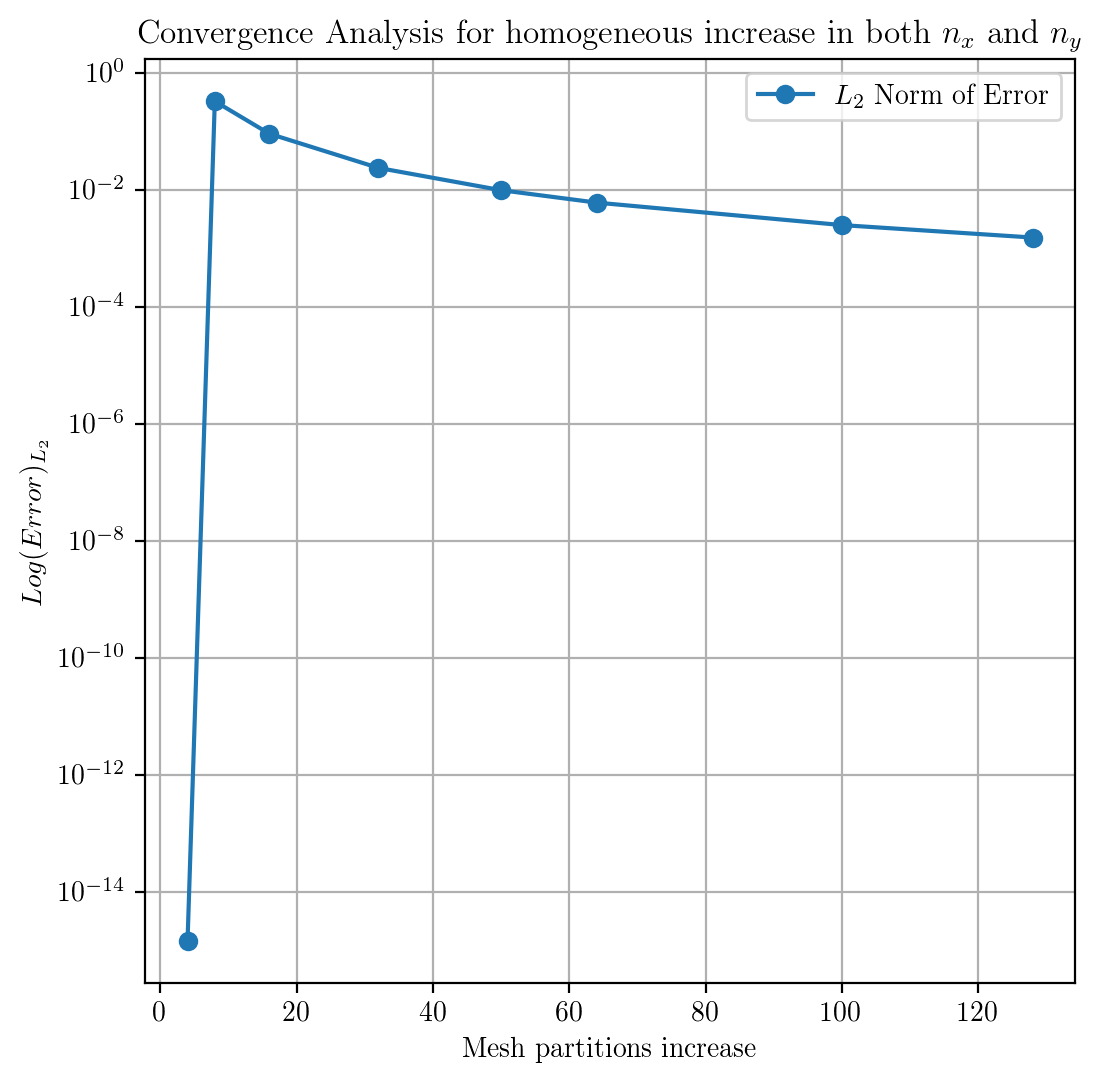

In [17]:
errors = []

for h in mesh_partitions:
    nx = int(h/2)
    ny = h
    u_approx, nodes = FEM.FEM_solver(w, h, nx, ny, source_function)
    # Assume numerical_solution and analytical_solution are sampled at the same points
    # Compute error
    error = np.linalg.norm(u_approx - analytical_solution(nodes[:,0],nodes[:,1]), ord=2)
    errors.append(error)

# Plotting convergence
plt.figure(figsize=(6, 6))
plt.plot(mesh_partitions, errors, '-o', label='$L_{2}$ Norm of Error')
plt.xlabel('Mesh partitions increase')
plt.ylabel('$Log(Error)_{L_{2}}$')
plt.title('Convergence Analysis for homogeneous increase in both $n_{x}$ and $n_{y}$')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

## Future work

We have implemented a very raw Finite Element Solver for the Poisson's equation in 2D. 

1) Although the method seems to be work, it is necessary to develop an efficient algorithm to optimize the convergence of the error. We have seen that different ways of refining the mesh leads to different type of convergence. We still need to implement convergence theory. 

2) I would like to include in the future an object in which all the information  about our domain $\Omega$ can be accesed via attributes. As well as the functions to be accesible through the object. 

3) Additionally, would be interesting to better store data in a dictionary to describe all the properties of the mesh we are generating.

4) Another possible thing to do, is to instead of increasing the number of nodes rather interpolate more points using barycentric coordinates within each element. It might need more slicing of matrices but we avoid increasing complexity by increasing the size of the matrices when inverting. 